Charger les images: toutes les images COVID + autant d'images Pneumonie + Lung Opacity.

Visualiser un ensemble d'images aléatoire.

CNN minimal avec 1 couche de convolution et une dense.

_Résult_: le score de bonnes prédictions  et les F1-scores oscillent autour de 0.77-0.8.

V2. Improve the function 'load_images' (previous projects 2,3), add the option to choose
random seed for a RandomGenerator.
_Résult_: la sélection des images est reproductible,
la matrice de confusion varie dans les limites d'une dizaine d'unités.

3 classes. Le scode est identique à celui du SVM. On remarque cependant que la classe 1 (malade non-COVID) est relativement mieux séparée, alors que les deux autres se mélangent plus souvent.

L'environnement s'appelle 'DSTest__proj_env06' sur ma machine. On trouve les versions des librairies dans la 2e cellule de code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os

import cv2

from sklearn.model_selection import train_test_split
from sklearn import metrics


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from timeit import default_timer as timer

import time

image_path = '../data'

2024-07-12 20:09:00.183958: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 20:09:00.208817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Added for checking versions.

import matplotlib
import sklearn
import tensorflow as tf

print(np.__version__)  # 1.26.4
print(matplotlib.__version__)  # 3.8.4
print(sklearn.__version__)  # 1.5.1
print(cv2.__version__)  # 4.9.0
print(tf.__version__)   # 2.13.1

1.26.4
3.8.4
1.5.1
4.9.0
2.13.1


Fonctions pour charger les images (adapté de: 'RF_data_augmentation.ipynb').

In [3]:
# Hyperparamètres (réduction de l'image)
IMG_HEIGHT = 28
IMG_WIDTH = 28

# L'architecture du CNN peut aussi être déplacée ici.

In [4]:
def list_img(image_dir: str, sought_ext='.png'):
    """
    List of files with a specific extension in a folder.

    Useful for extracting the number of files.
    Can also be used as the first step of the next version of function 'load_images'.

    Args:
        image_dir (str): path to folder
        sought_ext (str, optional): sought extension. Defaults to '.png'.

    Returns:
        list of str: the list of image files in the order of os.listdir.
    """
    files = os.listdir(image_dir)
    lst_images = [file_name for file_name in files if file_name.endswith(sought_ext)]
    return lst_images

In [5]:
def load_images(image_dir, label, limit=None, random_state=None):
    """
    Fonction pour charger les images d'un dossier.
    
    Args:
        image_dir (str): path to folder
        label (str or int): the label to associate to the images
        limit (int, optional): the max number of files to load.
            Defaults to None (load all PNG images).

    Constants imported from higher level: 
        IMG_HEIGHT, IMG_WIDTH

    Called by the function: load_data.

    Returns:
        tensor NImages x HEIGHT x WIDTH x 1: the images resized to HEIGHT x WIDTH;
        1d array (NImages,) : the label expanded to array.
    
    Possible improvements.
    1. Speed up the function by preallocating the tensor first,
    then writing into it.

    4. Return the  filenames of the extracted images as a 3rd output.
    """
    image_data = []
    label_data = []
    rng = np.random.default_rng(seed=random_state)

    all_files = list_img(image_dir)
    
    if limit:
        files = rng.choice(all_files, size=limit, replace=False)
        
    for file_name in files:
        img_path = os.path.join(image_dir, file_name)
        try:
            # Read the grayscale image as: HEIGHT x WIDTH x 1
            
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = np.expand_dims(img, axis=-1)
            
            img = img / 255.0
            image_data.append(img)
            label_data.append(label)
        except Exception as e:
            print(f"Erreur de chargement de l'image {file_name} : {e}")
    
    return np.array(image_data), np.array(label_data)

In [6]:
def load_data(image_dirs, labels, limits=None, random_state=None):
    """
    Load data from several folders

    Args:
        image_dirs (list of 'str'): the paths to folders.
        labels (list of 'str' of the same length): _description_
        limits (list if int of None, optional): the number of files to load.
            Defaults to None.

    Returns:
        tensor sum_{folders}(NImages) x HEIGHT x WIDTH :
            the images resized to HEIGHT x WIDTH;
        1d array (sum_{folders}(NImages),) : the labels expanded to array.
    """
    all_images = []
    all_labels = []
    
    limits2 = [None] * len(image_dirs) if limits is None else limits
    
    for i, image_dir in enumerate(image_dirs):
        images, label_data = load_images(image_dir,
                                        labels[i],
                                        limits2[i],
                                        random_state=random_state)
        all_images.append(images)
        all_labels.append(label_data)
    return np.concatenate(all_images), np.concatenate(all_labels)

In [7]:
def cond2folder(condition):
    return os.path.join(image_path, condition, "images")

Charger les images: 2500 COVID, (1250 Pneumo + 1250 Opacity), 2500 normaux choisies aléatoirement 

In [8]:
lst_conditions = ['COVID', 'Viral Pneumonia', 'Lung_Opacity', 'Normal']
lst_dirs = list(map(cond2folder, lst_conditions))
print(lst_dirs)

lst_labels = [2, 1, 1, 0]

print("labels:", lst_labels)

# determine the number of images to load
# num_COVID_img = len(list_img(lst_dirs[0]))
lst_nums_images = list(map(lambda path_dir: len(list_img(path_dir)), lst_dirs ))
print("Total number of images for each condition:", lst_nums_images)
# [3616, 6012, 1345]


['../data/COVID/images', '../data/Viral Pneumonia/images', '../data/Lung_Opacity/images', '../data/Normal/images']
labels: [2, 1, 1, 0]
Total number of images for each condition: [3616, 1345, 6012, 10192]


In [9]:
# Number of images to extract:
num_img_COV = 2500

balanced_lst_nums_images = [num_img_COV, num_img_COV//2, num_img_COV//2, num_img_COV]

print(balanced_lst_nums_images)
# [3616 2955 661] # -> ...


[2500, 1250, 1250, 2500]


Extract images.

In [10]:
start = time.time()
# data, labels = load_data(lst_dirs, lst_labels, balanced_lst_nums_images)
data, labels = load_data(lst_dirs,
                        lst_labels,
                        balanced_lst_nums_images,
                        random_state=42)
done = time.time()

elapsed = done - start
print(f'Loading data : {elapsed:.2f} sec \n\n')
# 7 sec

print(type(data))  # ndarray
print(data.shape)  # (7232, 28, 28, 1)

print(type(labels))  # ndarray
print(labels.shape)  # (7232,)

Loading data : 7.16 sec 


<class 'numpy.ndarray'>
(7500, 28, 28, 1)
<class 'numpy.ndarray'>
(7500,)


Ancien chargement des images: toutes les images COVID + autant d'images Pneumonie + Lung Opacity, que COVID.

In [11]:
"""
lst_conditions = ['COVID', 'Lung_Opacity', 'Viral Pneumonia']
lst_dirs = list(map(cond2folder, lst_conditions))
print(lst_dirs)

lst_labels = [1, 0, 0]

print("labels:", lst_labels)

# determine the number of images to load
# num_COVID_img = len(list_img(lst_dirs[0]))
lst_nums_images = list(map(lambda path_dir: len(list_img(path_dir)), lst_dirs ))
print("Total number of images for each condition:", lst_nums_images)
# [3616, 6012, 1345]
"""

'\nlst_conditions = [\'COVID\', \'Lung_Opacity\', \'Viral Pneumonia\']\nlst_dirs = list(map(cond2folder, lst_conditions))\nprint(lst_dirs)\n\nlst_labels = [1, 0, 0]\n\nprint("labels:", lst_labels)\n\n# determine the number of images to load\n# num_COVID_img = len(list_img(lst_dirs[0]))\nlst_nums_images = list(map(lambda path_dir: len(list_img(path_dir)), lst_dirs ))\nprint("Total number of images for each condition:", lst_nums_images)\n# [3616, 6012, 1345]\n'

In [12]:
# Number of images to extract.

# def scale_arr_to_sum(arr_to_scale:np.ndarray, new_sum):
"""
    Scales an array to (approximately) fit the new sum.
    The new array is rounded and converted to integers.
    
    Args:
        arr_to_scale (1-dimensional np.ndarray): the original array
        new_sum (scalar): the new sum
    """
    # coeff = new_sum / arr_to_scale.sum()
    # return (np.round(coeff * arr_to_scale)).astype(int)


# def scale_tail_to_match_head(arr):
"""
    Scales the slice of 'arr' without the 1st element
    so that its sum approximately matches the 1st element.
    The input is converted to a numpy array.

    Args:
        arr (list or ndarray of ints): the original array

    Returns:
        ndarray of ints: the rescaled array, where the 1st element is close to half of the total sum.
    """
    # res = np.array(arr)
    #res[1:] = scale_arr_to_sum(res[1:], arr[0])
    #return res

"""
# Check the function
print(scale_arr_to_sum(np.arange(5), 25))
# [ 0  2  5  8 10]

print(scale_tail_to_match_head(np.arange(50, 10, -10)))
# [50 22 17 11]
"""

'\n# Check the function\nprint(scale_arr_to_sum(np.arange(5), 25))\n# [ 0  2  5  8 10]\n\nprint(scale_tail_to_match_head(np.arange(50, 10, -10)))\n# [50 22 17 11]\n'

In [13]:
"""
balanced_lst_nums_images = scale_tail_to_match_head(lst_nums_images)

print(balanced_lst_nums_images)
# [3616 2955  661]
"""

'\nbalanced_lst_nums_images = scale_tail_to_match_head(lst_nums_images)\n\nprint(balanced_lst_nums_images)\n# [3616 2955  661]\n'

Extract images.

In [14]:
"""
start = time.time()
# data, labels = load_data(lst_dirs, lst_labels, balanced_lst_nums_images)
data, labels = load_data(lst_dirs,
                        lst_labels,
                        balanced_lst_nums_images,
                        random_state=42)
done = time.time()

elapsed = done - start
print(f'Loading data : {elapsed:.2f} sec \n\n')
# 6.6 sec

print(type(data))  # ndarray
print(data.shape)  # (7232, 28, 28, 1)

print(type(labels))  # ndarray
print(labels.shape)  # (7232,)
"""


"\nstart = time.time()\n# data, labels = load_data(lst_dirs, lst_labels, balanced_lst_nums_images)\ndata, labels = load_data(lst_dirs,\n                        lst_labels,\n                        balanced_lst_nums_images,\n                        random_state=42)\ndone = time.time()\n\nelapsed = done - start\nprint(f'Loading data : {elapsed:.2f} sec \n\n')\n# 6.6 sec\n\nprint(type(data))  # ndarray\nprint(data.shape)  # (7232, 28, 28, 1)\n\nprint(type(labels))  # ndarray\nprint(labels.shape)  # (7232,)\n"

Show random images.

In [15]:
def subplots_random_images(tens_img: np.ndarray, labels, n_plots: int, rng):
    """
    Plot random images from the tensor 'tens_img'.

    Args:
        tens_img (3d or 4d tensor): images.
        labels (1d array-like): the labels of images.
        n_plots (int): the number of images to plot.
        rng : the random number generator

    Returns:
        fig; ax; the indices of plotted images.
    
    Possible improvement: make the 2 last parameters optional.
    """
    indices = rng.choice(tens_img.shape[0], size=n_plots, replace=False)

    fig, axes = plt.subplots(1, n_plots)
    fig.set_figheight(5)
    fig.set_figwidth(16)
    for n_plot in range(n_plots):
        axes[n_plot].imshow(tens_img.take(indices[n_plot], axis=0),
                        cmap='gray')
        axes[n_plot].set_title(labels[indices[n_plot]])
    return fig, axes, indices

(<Figure size 1600x500 with 6 Axes>,
 array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '2'}>],
       dtype=object),
 array([5661, 3836, 7126, 3546, 1081,  261]))

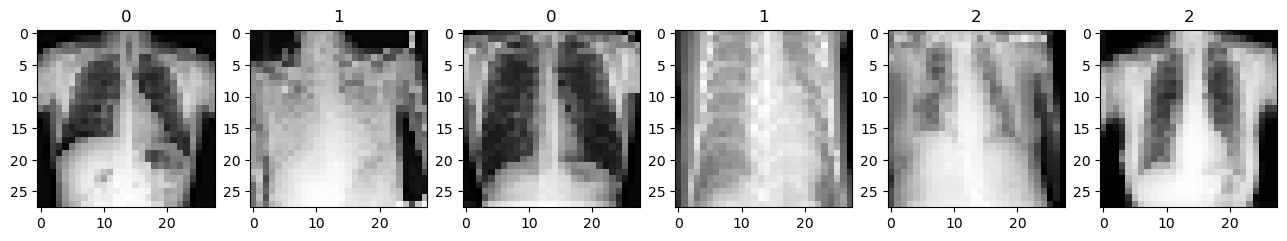

In [16]:
n_plots = 6

# Show 'n_plots' random indices.
rng = np.random.default_rng(1)

subplots_random_images(data, labels, n_plots, rng)

In [17]:
# Check the distribution of labels.
lbl_unique, lbl_counts = np.unique(labels, return_counts=True)

print(lbl_unique)  # ['0 1 2]
print('--------')
print(lbl_counts)  # [2500 2500 2500]

# As expected, the classes are balanced.


[0 1 2]
--------
[2500 2500 2500]


# Train-Test split

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=labels)

print(X_train.shape)  # (5250, 28, 28, 1)
print(X_test.shape)   # (5250, 28, 28, 1)

(5250, 28, 28, 1)
(2250, 28, 28, 1)


labels -> categorical

In [19]:
# (f)
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(Y_test.shape)  # should be: (5250, 3)
print(Y_test[:3, :]) # First true values: 

(2250, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


# Générateur de données
(vient du notebook 3 du module CNN)

In [20]:
train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator()


In [21]:
train_dataset = train_datagen.flow(X_train,Y_train,
                        batch_size = 128)
"""
Fails with Grayscale images!
See: https://stackoverflow.com/a/65182852

train_dataset = train_datagen.flow(X_train,Y_train,
                        batch_size = 128,
                        color_mode="grayscale")
->
TypeError: flow() got an unexpected keyword argument 'color_mode'

"""

test_dataset = test_datagen.flow(X_test, Y_test, batch_size = 128)

#  Callbacks


In [22]:
# from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

Dans le cadre de notre modèle, on utilisera deux callbacks : Un Early Stop et un Learning rate reducer.

In [23]:
early_stopping = EarlyStopping(
                                patience=5, # Attendre 5 epochs avant application
                                min_delta = 0.01, # si au bout de 5 epochs la fonction de perte ne varie pas de 1%, 
    # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, #si val_loss stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.01,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 4, # On attend 4 epochs avant de réitérer 
                                    verbose=1)

time_callback = TimingCallback()

# This defined components of a CNN, but neither built a model,
# nor required resources from the machine.

# Construction d'un CNN Classique

* Couche de Convolution comportant les paramètres suivants :
    * filters = 32: La couche sera composée de 32 matrices de convolution.
    * kernel_size = (3, 3) : le noyau de convolution sera de dimension 3x3.
    * activation = 'relu'.
    * input_shape =  (100,100,3).
    * On ajoutera les paramètres padding = 'valid' et kernel_regularizer=regularizers.l2(0.00001).

* Couche de Max Pooling avec comme paramètres :
    * pool_size = 2
    * strides = 2
    * padding = 'valid'

* Couche de Dropout avec le paramètre rate = 0.5

* Couche d'applatissement

* Couche dense à 1 neurone. 

    * model.add(Dense(1, activation='sigmoid'))


In [24]:
# Instanciation du modèle 
model = Sequential()

model.add(Conv2D(filters=8,
                  kernel_size=(3,3),
                  activation="relu",
                  padding="valid",
                  input_shape=(28, 28, 1))
            )

model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(Y_train.shape[1], activation='softmax'))

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 8)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 8)         0         
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 dense (Dense)               (None, 3)                 4059      
                                                                 
Total params: 4139 (16.17 KB)
Trainable params: 4139 (16.17 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

# Entraînement du modèle


In [26]:
#Compilation du modèle
model.compile(optimizer="adam",
                loss="categorical_crossentropy",
                metrics=['acc'])

In [27]:
# Entrainement du modèle, utiliser le jeu de données augmenté, et préciser les callbacks.

batch_size = 128
epochs = 20

start = time.time()
model_history = model.fit(
            train_dataset, # use augmented images for train 
            steps_per_epoch=X_train.shape[0] // batch_size,
            validation_data = test_dataset, # use augmented images for test  
            epochs = epochs,
            callbacks = [
                        reduce_learning_rate,
                        early_stopping,
                        time_callback
                        ],
            verbose=True)

done = time.time()

elapsed = done - start
print(f'Training : {elapsed:.2f} sec \n\n')
# 19 sec


Epoch 1/20
41/41 [==============================] - 1s 23ms/step - loss: 1.0570 - acc: 0.4490 - val_loss: 0.9881 - val_acc: 0.5516 - lr: 0.0010
Epoch 2/20
41/41 [==============================] - 1s 28ms/step - loss: 0.9733 - acc: 0.5326 - val_loss: 0.8917 - val_acc: 0.6209 - lr: 0.0010
Epoch 3/20
41/41 [==============================] - 1s 25ms/step - loss: 0.9260 - acc: 0.5609 - val_loss: 0.8489 - val_acc: 0.6182 - lr: 0.0010
Epoch 4/20
41/41 [==============================] - 1s 25ms/step - loss: 0.8841 - acc: 0.5925 - val_loss: 0.8209 - val_acc: 0.6311 - lr: 0.0010
Epoch 5/20
41/41 [==============================] - 1s 24ms/step - loss: 0.8706 - acc: 0.5920 - val_loss: 0.8156 - val_acc: 0.6196 - lr: 0.0010
Epoch 6/20
41/41 [==============================] - 1s 23ms/step - loss: 0.8581 - acc: 0.6039 - val_loss: 0.7984 - val_acc: 0.6382 - lr: 0.0010
Epoch 7/20
41/41 [==============================] - 1s 24ms/step - loss: 0.8461 - acc: 0.6125 - val_loss: 0.7934 - val_acc: 0.6373 - lr:

# Performances du modèle

In [28]:
val_acc = model_history.history['val_acc']

print(type(val_acc))


<class 'list'>


Text(0, 0.5, 'Accuracy on validation set.')

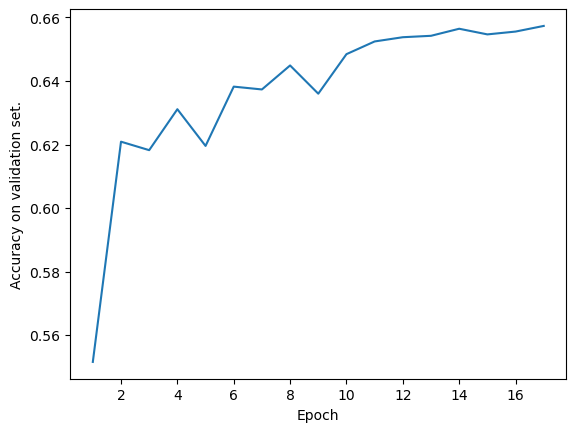

In [29]:
# (g) Tracer l'évolution des précisions tout au long de l'entraînement.
plt.plot(range(1, len(val_acc) + 1), val_acc)

plt.xlabel("Epoch")
plt.ylabel("Accuracy on validation set.")

Prédictions sur l'ensemble test. TOADAPT to matrix of Y_test

In [30]:
# (i)
start = time.time()
test_pred = model.predict(X_test)
done = time.time()

elapsed = done - start
print(f'Prediction : {elapsed:.2f} sec \n\n')
# 0.2 sec

print(type(test_pred))  # ndarray
print(test_pred.shape)  # (2170, 1)

print(test_pred[:3, :])  # The first predictions: 1, 1, 1. 
# They are correct, although the model is only certain about the second one.

71/71 [==============================] - 0s 951us/step
Prediction : 0.19 sec 


<class 'numpy.ndarray'>
(2250, 3)
[[0.8304713  0.05365103 0.11587769]
 [0.3318995  0.06730037 0.6008001 ]
 [0.5384116  0.12920646 0.33238187]]


In [31]:
# (k)
def pred_mat2class(pred_matrix):
    return pred_matrix.argmax(axis=1)


y_test_class = pred_mat2class(Y_test)
test_pred_class = pred_mat2class(test_pred)


print(test_pred_class[:10])  # [7 2 1 0 4 1 4 9 6 9]
# (la 9ème prédiction diffère de l'exercice 1 et du notebook)



[0 2 0 0 0 2 0 2 1 2]


In [32]:
"""
test_pred_class = (test_pred > 0.5).astype(int).ravel()

print(test_pred_class.shape)  # (2170, 1)

print(test_pred_class[:3])  # The first predictions: 1, 1, 1.
"""

'\ntest_pred_class = (test_pred > 0.5).astype(int).ravel()\n\nprint(test_pred_class.shape)  # (2170, 1)\n\nprint(test_pred_class[:3])  # The first predictions: 1, 1, 1.\n'

In [33]:
print(y_test_class[:10])  # [1, 1, 1]

[0 0 2 0 0 2 2 0 1 2]


In [34]:
# score
print("Accuracy on test set:", metrics.accuracy_score(y_test_class, test_pred_class))

Accuracy on test set: 0.6573333333333333


In [35]:
print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.60      0.71      0.65       750
           1       0.73      0.71      0.72       750
           2       0.65      0.55      0.60       750

    accuracy                           0.66      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.66      0.66      0.66      2250



In [36]:
# confusion matrix
cm = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cm)

[[534  98 118]
 [115 535 100]
 [243  97 410]]
